In [1]:
import os
import sys
from pathlib import Path

import jupyter_compare_view
import leafmap
import numpy as np
import rasterio
from samgeo import tms_to_geotiff

Jupyter compare_view v0.2.4


In [2]:
%env SM_FRAMEWORK=tf.keras

# Add the parent directory to the path to make imports work
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from predict import get_smooth_prediction_for_file
from utils import prepare_split_image

env: SM_FRAMEWORK=tf.keras


2023-06-16 12:23:48.861480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:23:49.905675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [3]:
zoom = 18

m = leafmap.Map(center=[52.49442707602441, 13.434820704132562], zoom=zoom)
m.add_basemap("SATELLITE")
m

Map(center=[52.49442707602441, 13.434820704132562], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [4]:
# Get selection from map and download image
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()

    image = f"../data/predict/app/source/satellite-from-leafmap-{np.random.randint(10000, 99999)}.tif"
    tms_to_geotiff(output=image, bbox=bbox, zoom=zoom+1, source="Satellite", overwrite=True)

else:
    print("No bounding box selected")

Downloaded image 01/16
Downloaded image 02/16
Downloaded image 03/16
Downloaded image 04/16
Downloaded image 05/16
Downloaded image 06/16
Downloaded image 07/16
Downloaded image 08/16
Downloaded image 09/16
Downloaded image 10/16
Downloaded image 11/16
Downloaded image 12/16
Downloaded image 13/16
Downloaded image 14/16
Downloaded image 15/16
Downloaded image 16/16
Saving GeoTIFF. Please wait...
Image saved to ../data/predict/app/source/satellite-from-leafmap-90683.tif


In [5]:
# Get the prediction
model_path = Path(
    "../data/models/landcover_25_epochs_resnet34_backbone_batch16_iou_0.76.hdf5"
)

with rasterio.open(image) as dataset:
    img_array = dataset.read()

# Move channel information to third axis
img_array = np.moveaxis(img_array, source=0, destination=2)

prediction = get_smooth_prediction_for_file(
    img_array, model_path, 5, "resnet34", patch_size=256
)

  0%|          | 0/8 [00:00<?, ?it/s]

2/2 [==============================] - 10s 3s/step


 12%|█▎        | 1/8 [00:11<01:20, 11.54s/it]

2/2 [==============================] - 8s 3s/step


 25%|██▌       | 2/8 [00:21<01:02, 10.42s/it]

2/2 [==============================] - 8s 3s/step


 38%|███▊      | 3/8 [00:30<00:50, 10.13s/it]

2/2 [==============================] - 9s 4s/step


 50%|█████     | 4/8 [00:42<00:42, 10.52s/it]

2/2 [==============================] - 10s 4s/step


 62%|██████▎   | 5/8 [01:04<00:44, 14.74s/it]

2/2 [==============================] - 12s 4s/step


 75%|███████▌  | 6/8 [01:18<00:29, 14.56s/it]

2/2 [==============================] - 10s 4s/step


 88%|████████▊ | 7/8 [01:29<00:13, 13.52s/it]

2/2 [==============================] - 10s 3s/step


100%|██████████| 8/8 [01:52<00:00, 14.04s/it]


In [6]:
# Prepare images for visualization
img, segmented_img, overlay = prepare_split_image(img_array, prediction)


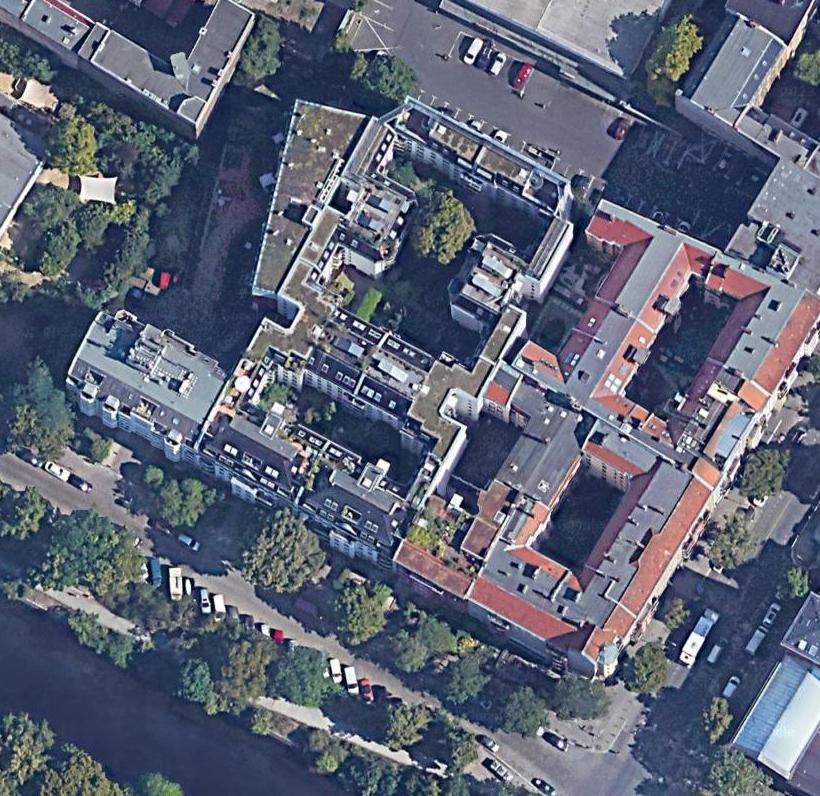
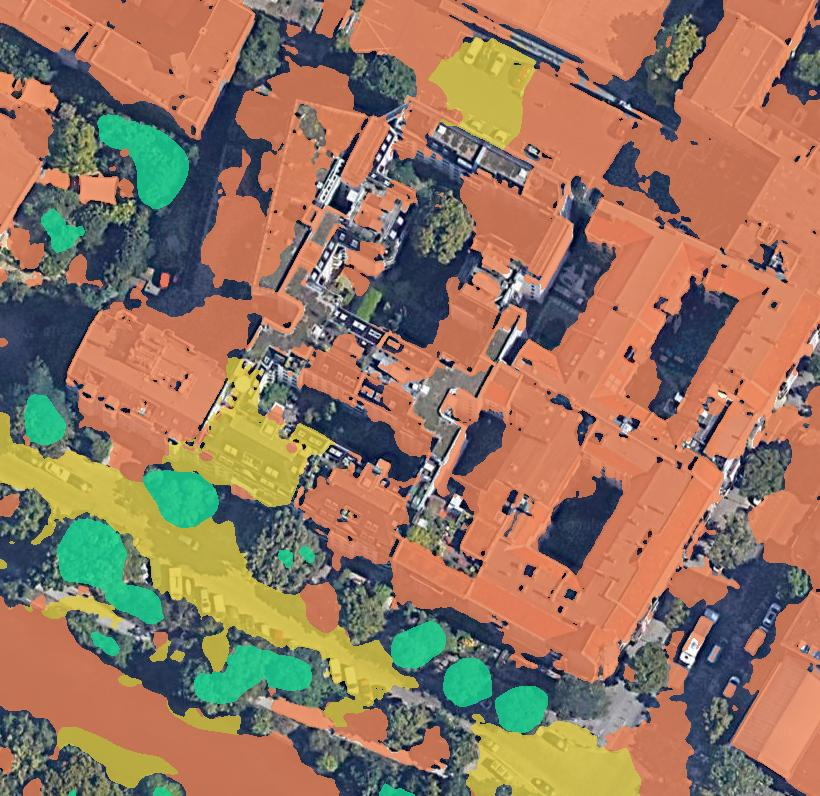

In [7]:
# Show results
jupyter_compare_view.compare(
    img.convert("RGB"),
    overlay.convert("RGB"),
    start_mode="horizontal",
    start_slider_pos=0.5,
)